In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
!pip install ta
import ta  # technical analysis library, install with: pip install ta

tickers = ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'TSLA']

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=d9a68f2407eed333a701dac2a703b0752694e6ea2d8d6285ce414a8cf74fd515
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


In [3]:
data = yf.download(tickers, start='2018-01-01', end='2025-01-01', group_by='ticker', auto_adjust=True)

[*********************100%***********************]  5 of 5 completed


In [4]:
# Reshape to long format
df_list = []
for ticker in tickers:
    df_temp = data[ticker].copy()
    df_temp['Ticker'] = ticker
    df_temp.reset_index(inplace=True)
    df_list.append(df_temp)

df = pd.concat(df_list, ignore_index=True)

# Set multi-index
df.set_index(['Date', 'Ticker'], inplace=True)

In [5]:
# Calculate features group-wise by ticker
def add_features(group):
    group = group.copy()
    group['return_1d'] = group['Close'].pct_change(1)
    group['return_3d'] = group['Close'].pct_change(3)
    group['sma_5'] = group['Close'].rolling(window=5).mean()
    group['sma_20'] = group['Close'].rolling(window=20).mean()
    group['rsi_14'] = ta.momentum.RSIIndicator(close=group['Close'], window=14).rsi()
    group['volatility_5d'] = group['return_1d'].rolling(window=5).std()
    group['volume_change_1d'] = group['Volume'].pct_change(1)
    return group

df = df.groupby('Ticker').apply(add_features)

In [6]:
def add_target(group):
    group = group.copy()
    group['future_return_3d'] = group['Close'].shift(-3) / group['Close'] - 1
    group['target'] = (group['future_return_3d'] > 0).astype(int)
    return group

df = df.groupby('Ticker').apply(add_target)

In [7]:
df.dropna(inplace=True)

In [8]:
# Get all unique dates sorted
unique_dates = df.index.get_level_values(0).unique().sort_values()

split_date = unique_dates[int(len(unique_dates)*0.8)]

train_data = df.loc[df.index.get_level_values(0) < split_date]
test_data = df.loc[df.index.get_level_values(0) >= split_date]

print(f"Train size: {len(train_data)}, Test size: {len(test_data)}")

Train size: 6956, Test size: 1739


In [9]:
features = ['return_1d', 'return_3d', 'sma_5', 'sma_20', 'rsi_14', 'volatility_5d', 'volume_change_1d']

X_train = train_data[features]
y_train = train_data['target']

X_test = test_data[features]
y_test = test_data['target']

In [13]:
!pip install --upgrade lightgbm

In [17]:
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

# 1. Initialize LightGBM Classifier
model = LGBMClassifier(
    n_estimators=500,
    learning_rate=0.01,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# 2. Fit model with early stopping
model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='logloss',
)

# 3. Predict probability for class 1 (i.e., "price will go up")
proba = model.predict_proba(X_test)[:, 1]

# 4. Set threshold to filter strong signals
threshold = 0.6
signals = proba > threshold

# 5. Align future returns (you already calculated `future_returns` with .shift(-3))
strategy_returns = df['future_return_3d'].loc[y_test.index][signals]
benchmark_returns = df['future_return_3d'].loc[y_test.index]

strategy_returns = strategy_returns.dropna()
benchmark_returns = benchmark_returns.dropna()

strategy_returns = strategy_returns.dropna()
benchmark_returns = benchmark_returns.dropna()

# # 6. Plot cumulative returns
# plt.figure(figsize=(10, 6))
# (strategy_returns.fillna(0).cumsum()).plot(label='Strategy', lw=2)
# (benchmark_returns.fillna(0).cumsum()).plot(label='Benchmark', lw=2)
# plt.title("Cumulative Returns")
# plt.xlabel("Time")
# plt.ylabel("Return")
# plt.legend()
# plt.grid(True)
# plt.show()

# # 7. Optional: Classification report
# print("Accuracy:", accuracy_score(y_test, model.predict(X_test)))
# print(classification_report(y_test, model.predict(X_test)))


[LightGBM] [Info] Number of positive: 3892, number of negative: 3064
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000744 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 6956, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.559517 -> initscore=0.239202
[LightGBM] [Info] Start training from score 0.239202
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

In [18]:
print("Accuracy:", accuracy_score(y_test, model.predict(X_test)))
print(classification_report(y_test, model.predict(X_test)))

Accuracy: 0.48533640023001723
              precision    recall  f1-score   support

           0       0.39      0.18      0.25       816
           1       0.51      0.75      0.61       923

    accuracy                           0.49      1739
   macro avg       0.45      0.47      0.43      1739
weighted avg       0.46      0.49      0.44      1739



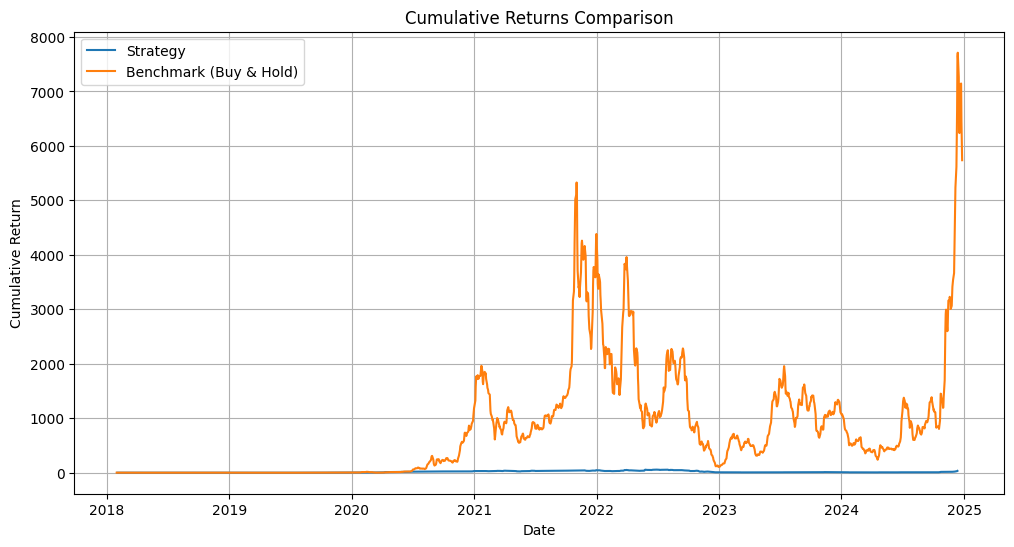

In [22]:
plt.figure(figsize=(12,6))
plt.plot(cumulative_strategy_returns.index.get_level_values('Date'), cumulative_strategy_returns.values, label='Strategy')
plt.plot(cumulative_benchmark_returns.index.get_level_values('Date'), cumulative_benchmark_returns.values, label='Benchmark (Buy & Hold)')
plt.title('Cumulative Returns Comparison')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()